In [ ]:
! pip install aequitas

In [2]:
from faker import Faker
import random 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [3]:
fake = Faker()


N = 200
customers = [fake.name() for i in range(N)]
customer_ids = [fake.uuid4()[-6:] for i in range(N)]


categories = ['Food', 'Cafe', 'Hotel', 'Grocery', 'Supermarket', 'GasStation', 'NetBanking', 'Ecommerce', 'Pharmacy', 'Electronics', 'Healthcare']
N = 20
offers = [fake.domain_name() for i in range(N)]
offer_cats = [random.choice(categories) for i in range(N)]
offer_ids = [fake.uuid4()[-6:] for i in range(N)]
merchants = [fake.domain_name() for i in range(N)]

rows = []
for i in range(1000):
    cust = random.choice(customers)
    idx = customers.index(cust)
    
    offer = random.choice(offers)
    idxo = offers.index(offer)
    
    
    d = {
        'CustomerID' : customer_ids[idx],
        # 'Customer_Recency' : fake.random_int(1, 100) / 100,
        # 'Customer_Monetary' : fake.random_int(1, 100) / 100,
        # 'Customer_Frequency' : fake.random_int(1, 100) / 100,
        'OfferID' : offer_ids[idxo],
        'CustomerName' : cust,
        'Offer' : offer,
        'merchant' : merchants[idxo],
        'Category' : offer_cats[idxo],
        'Propensity' : fake.random_int(1,90) / 100,
        "PredictionTime" : fake.random_int(1,79) / 10,
        "Actual" : fake.random_int(0, 1)
    }
    
    rows.append(d)


In [4]:
df = pd.DataFrame(rows)
df.head()

,CustomerID,OfferID,CustomerName,Offer,merchant,Category,Propensity,PredictionTime,Actual
0,449657,852b38,Megan Alexander,castro.org,johnson.com,Healthcare,0.59,7.4,1
1,b687bd,9c3316,Andrea Young,arnold.com,rivera-ruiz.info,Cafe,0.70,5.6,0
2,6162d0,2a0034,Misty Mack,salazar.com,henderson.info,Supermarket,0.32,2.0,0
3,17b949,b1b3c0,Aaron Livingston,browning.info,riley-walker.info,Hotel,0.67,0.3,1
4,8dc4a8,8190e4,Darryl Mccann,morgan.com,daniels.info,Ecommerce,0.60,5.5,1


In [81]:
class BDFAnalyzer(object):  
    """ Model Bias, Disparity & Fairness Analyzer. 

    Predicted Positive Group Rate Disparity -> pprev
    Predicted Positive Rate Disparity       -> ppr
    False Discovery Rate                    -> fdr
    False Omission Rate                     -> for
    False Positive Rate                     -> fpr
    False Negative Rate                     -> fnr
    """
    def __init__(self, df, feature_cols, score_col, binary_col):
        df_cols = ['entity_id', 'score', 'label_value']+feature_cols
        df = df.copy().reset_index().rename(columns={score_col: 'score', binary_col: 'label_value', 'index': 'entity_id'})
        df = df.loc[:, df_cols]
        df['score'] = df['score'].astype(float)
        df['label_value'] = df['label_value'].astype(float)
        self.df = df
        print(df.head())

        self.g = Group()
        self.xtab, _  = self.g.get_crosstabs(df)
        self.plotter = Plot()
        self.b = Bias()
        self.majority_bdf = self.b.get_disparity_major_group(self.xtab, df)
        self.minority_bdf = self.b.get_disparity_min_metric(self.xtab, original_df=df)
        self.f = Fairness()

    
    def get_absolute_metrics(self, normalized=False):
        absolute_metrics = self.g.list_absolute_metrics(self.xtab)
        if normalized:
            res_df = self.xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)
        else:
            res_df = self.xtab[[col for col in self.xtab.columns if col not in absolute_metrics]]
        return res_df

    def plot_metrics(self, metrics=[], nrows=20):
        if metrics == []:
            p = self.plotter.plot_group_metric_all(self.xtab.iloc[:nrows, :], ncols=3)
        else:
            p = self.plotter.plot_group_metric_all(self.xtab.iloc[:nrows, :], metrics=metrics, ncols=3)
        return p

    def plot_metric(self, metric='fpr', nrows=None, min_group_size=0.05):
        if not(nrows):
            p = self.plotter.plot_group_metric(self.xtab, metric, min_group_size=min_group_size)
        else:
            p = self.plotter.plot_group_metric(self.xtab.iloc[:nrows, :], metric, min_group_size=min_group_size)
        return p

    def get_majority_bdf(self):
        """Disparities calculated in relation to sample population majority group (in terms of group prevalence) for each attribute"""
        return self.majority_bdf[['attribute_name', 'attribute_value'] +  self.b.list_disparities(self.majority_bdf)]

    def get_minority_bdf(self):
        """Disparities calculated in relation to the minimum value for each metric"""
        return self.minority_bdf[['attribute_name', 'attribute_value'] +  self.b.list_disparities(self.minority_bdf)]

    def get_specific_disparity(self, group_dict):
        bdf = self.b.get_disparity_predefined_groups(self.xtab, original_df=self.df, 
                                        ref_groups_dict=group_dict, 
                                        alpha=0.05, #check_significance=True, 
                                        mask_significance=True)
        res_df = bdf[['attribute_name', 'attribute_value'] + self.b.list_disparities(bdf) + self.b.list_significance(bdf)]
        return res_df

    def plot_majority_disparity(self, attr, metric='fnr_disparity', alpha=0.05):

        p = self.plotter.plot_disparity(self.majority_bdf, group_metric=metric, attribute_name=attr, significance_alpha=alpha)
        return p 

    # def plot_minority_disparity(self, attr, metric='fnr_disparity', alpha=0.05):

    #     p = self.plotter.plot_disparity(self.minority_bdf, group_metric=metric, attribute_name=attr, significance_alpha=alpha)
    #     return p 

    # def plot_all_minority_disparities(self, attrs, alpha=0.05):
    #     p = self.plotter.plot_disparity_all(self.minority_bdf, attributes=attrs, significance_alpha=alpha)
    #     return p 

    def plot_all_majority_disparities(self, attrs, alpha=0.05):
        p = self.plotter.plot_disparity_all(self.majority_bdf, attributes=attrs, significance_alpha=alpha)
        return p 
    
    def plot_specific_disparity(self, group_dict, attrs, alpha=0.05, metrics=[]):
        bdf = self.b.get_disparity_predefined_groups(self.xtab, original_df=self.df, 
                                        ref_groups_dict=group_dict, 
                                        alpha=0.05, #check_significance=True, 
                                        mask_significance=True)

        p = self.plotter.plot_disparity_all(bdf, attributes=attrs, metrics=metrics, significance_alpha=alpha)
        return p 

    def get_relative_fairness(self, ref_group_dict, alpha=0.05, res_type='fairness'):
        absolute_metrics = self.g.list_absolute_metrics(self.xtab)
        bdf = self.b.get_disparity_predefined_groups(self.xtab, original_df=self.df, 
                                        ref_groups_dict=ref_group_dict, 
                                        alpha=alpha, #check_significance=True, 
                                        mask_significance=True)

        fdf = self.f.get_group_value_fairness(bdf)
        if res_type == 'parity':
            parity_detrminations = self.f.list_parities(fdf)
            res_df = fdf[['attribute_name', 'attribute_value'] + absolute_metrics + self.b.list_disparities(fdf) + parity_detrminations]
        elif res_type == 'grouped_fairness':
            res_df = self.f.get_group_attribute_fairness(fdf)
        else:
            res_df = fdf 
        return res_df

    def plot_relative_fairness(self, ref_group_dict, metrics=[], alpha=0.05):
        bdf = self.b.get_disparity_predefined_groups(self.xtab, original_df=self.df, 
                                        ref_groups_dict=ref_group_dict, 
                                        alpha=alpha, #check_significance=True, 
                                        mask_significance=True)

        fdf = self.f.get_group_value_fairness(bdf)
        if metrics == []:
            p = self.plotter.plot_fairness_group_all(fdf, ncols=3, metrics='all')
        else:
            p = self.plotter.plot_fairness_group_all(fdf, metrics=metrics, ncols=3)
        return p 

    def plot_relative_fairness_disparity(self, ref_group_dict, attrs, metrics=[], alpha=0.05):
        bdf = self.b.get_disparity_predefined_groups(self.xtab, original_df=self.df, 
                                        ref_groups_dict=ref_group_dict, 
                                        alpha=alpha, #check_significance=True, 
                                        mask_significance=True)

        fdf = self.f.get_group_value_fairness(bdf)
        if metrics == []:
            p = self.plotter.plot_fairness_disparity_all(fdf, attributes=attrs, metrics='all')
        else:
            p = self.plotter.plot_fairness_disparity_all(fdf, attributes=attrs, metrics=metrics)
        return p 

        
    

In [82]:
feat_cols = ['merchant', 'Category']
score_col = 'Propensity'
binary_col = 'Actual'

analyzer = BDFAnalyzer(df, feat_cols, score_col, binary_col)

   entity_id  score  label_value           merchant     Category
0          0   0.59          1.0        johnson.com   Healthcare
1          1   0.70          0.0   rivera-ruiz.info         Cafe
2          2   0.32          0.0     henderson.info  Supermarket
3          3   0.67          1.0  riley-walker.info        Hotel
4          4   0.60          1.0       daniels.info    Ecommerce
get_disparity_major_group()
get_disparity_min_metric()


In [83]:
a = analyzer.get_absolute_metrics()
a.head()

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,0,merchant,allen-wilson.com,0,44,0,24,20,0,24,20,44,1000
1,0,binary 0/1,0,merchant,ashley.org,0,44,0,19,25,0,19,25,44,1000
2,0,binary 0/1,0,merchant,burns.biz,0,42,0,19,23,0,19,23,42,1000
3,0,binary 0/1,0,merchant,clarke-romero.net,0,47,0,29,18,0,29,18,47,1000
4,0,binary 0/1,0,merchant,cook.com,0,47,0,21,26,0,21,26,47,1000


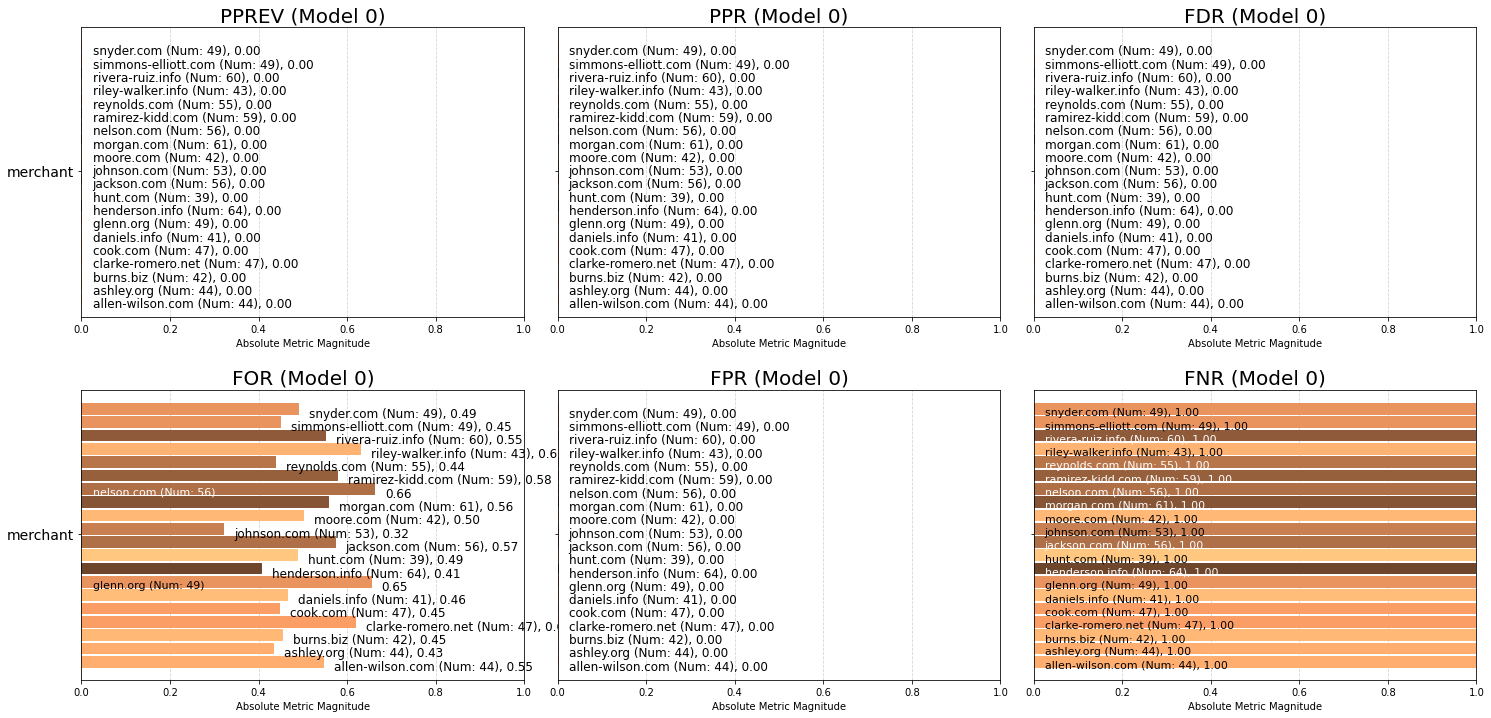

<Figure size 432x288 with 0 Axes>

In [84]:
a1 = analyzer.plot_metrics()

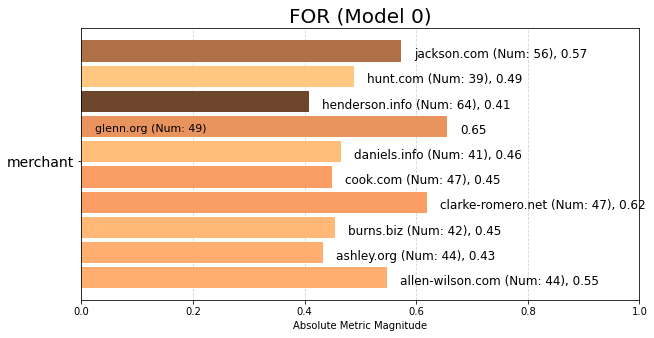

In [85]:
a2 = analyzer.plot_metric('for', nrows=10)

In [86]:
a3 = analyzer.get_majority_bdf()
a3.head()

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,merchant,allen-wilson.com,NaN,NaN,NaN,NaN,1.342657,NaN,1.0,NaN,1.0,0.765550
1,merchant,ashley.org,NaN,NaN,NaN,NaN,1.062937,NaN,1.0,NaN,1.0,0.956938
2,merchant,burns.biz,NaN,NaN,NaN,NaN,1.113553,NaN,1.0,NaN,1.0,0.922306
3,merchant,clarke-romero.net,NaN,NaN,NaN,NaN,1.518822,NaN,1.0,NaN,1.0,0.645017
4,merchant,cook.com,NaN,NaN,NaN,NaN,1.099836,NaN,1.0,NaN,1.0,0.931691


In [87]:
a4 = analyzer.get_minority_bdf()
a4.head()

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,merchant,allen-wilson.com,NaN,NaN,NaN,NaN,1.700535,NaN,1.0,NaN,1.0,1.339713
1,merchant,allen-wilson.com,NaN,NaN,NaN,NaN,1.700535,NaN,1.0,NaN,1.0,1.339713
2,merchant,ashley.org,NaN,NaN,NaN,NaN,1.346257,NaN,1.0,NaN,1.0,1.674641
3,merchant,ashley.org,NaN,NaN,NaN,NaN,1.346257,NaN,1.0,NaN,1.0,1.674641
4,merchant,burns.biz,NaN,NaN,NaN,NaN,1.410364,NaN,1.0,NaN,1.0,1.614035


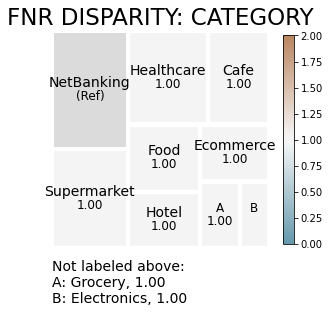

In [88]:
a5 = analyzer.plot_majority_disparity(attr='Category')

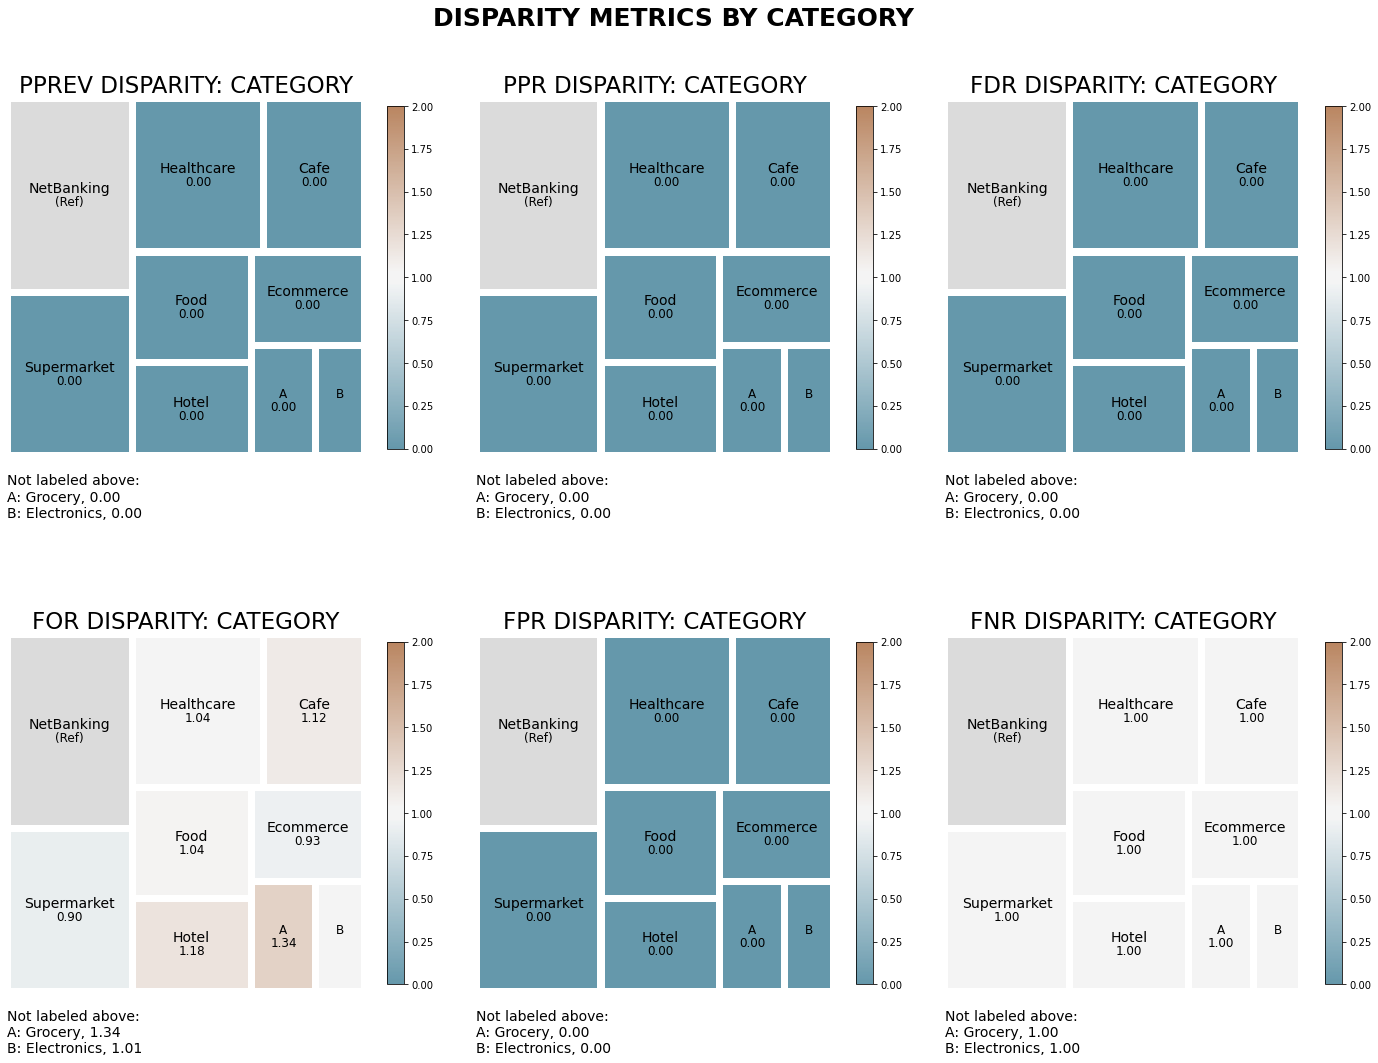

In [89]:
a6 = analyzer.plot_all_majority_disparities(attrs=['Category'])

get_disparity_predefined_group()


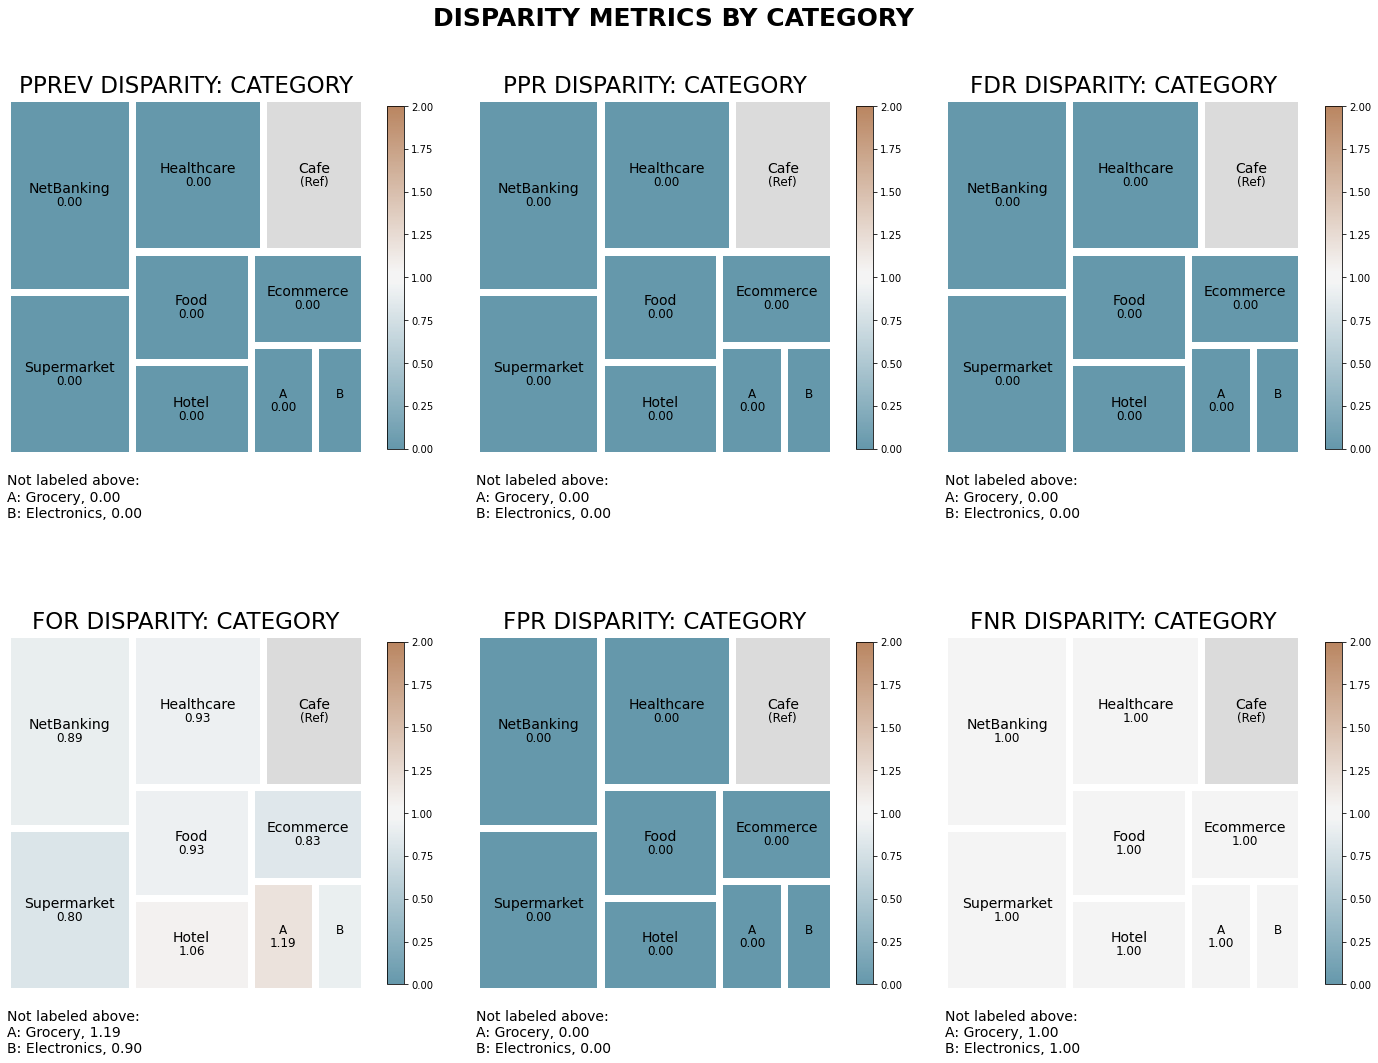

In [90]:
a7 = analyzer.plot_specific_disparity(group_dict={'Category': 'Cafe', 'merchant': 'johnson.com'}, attrs=['Category'], alpha=0.05)

In [91]:
a8 = analyzer.get_specific_disparity(group_dict={'Category': 'Cafe', 'merchant': 'johnson.com'})
a8.head()

get_disparity_predefined_group()


,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,merchant,allen-wilson.com,NaN,NaN,NaN,NaN,1.700535,NaN,1.0,NaN,1.0,0.669192
1,merchant,ashley.org,NaN,NaN,NaN,NaN,1.346257,NaN,1.0,NaN,1.0,0.836490
2,merchant,burns.biz,NaN,NaN,NaN,NaN,1.410364,NaN,1.0,NaN,1.0,0.806217
3,merchant,clarke-romero.net,NaN,NaN,NaN,NaN,1.923655,NaN,1.0,NaN,1.0,0.563830
4,merchant,cook.com,NaN,NaN,NaN,NaN,1.392991,NaN,1.0,NaN,1.0,0.814421


In [92]:
a9 = analyzer.get_relative_fairness(ref_group_dict={'Category': 'Cafe', 'merchant': 'johnson.com'})
a9.head()

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,0,merchant,allen-wilson.com,0.0,1.0,0.545455,NaN,0.0,...,True,NaN,True,False,NaN,NaN,False,NaN,NaN,False
1,0,binary 0/1,0,merchant,ashley.org,0.0,1.0,0.431818,NaN,0.0,...,True,NaN,True,True,NaN,NaN,False,NaN,NaN,False
2,0,binary 0/1,0,merchant,burns.biz,0.0,1.0,0.452381,NaN,0.0,...,True,NaN,True,True,NaN,NaN,False,NaN,NaN,False
3,0,binary 0/1,0,merchant,clarke-romero.net,0.0,1.0,0.617021,NaN,0.0,...,True,NaN,True,False,NaN,NaN,False,NaN,NaN,False
4,0,binary 0/1,0,merchant,cook.com,0.0,1.0,0.446809,NaN,0.0,...,True,NaN,True,True,NaN,NaN,False,NaN,NaN,False


In [93]:
a10 = analyzer.get_relative_fairness(ref_group_dict={'Category': 'Cafe', 'merchant': 'johnson.com'})
a10.head()

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,0,merchant,allen-wilson.com,0.0,1.0,0.545455,NaN,0.0,...,True,NaN,True,False,NaN,NaN,False,NaN,NaN,False
1,0,binary 0/1,0,merchant,ashley.org,0.0,1.0,0.431818,NaN,0.0,...,True,NaN,True,True,NaN,NaN,False,NaN,NaN,False
2,0,binary 0/1,0,merchant,burns.biz,0.0,1.0,0.452381,NaN,0.0,...,True,NaN,True,True,NaN,NaN,False,NaN,NaN,False
3,0,binary 0/1,0,merchant,clarke-romero.net,0.0,1.0,0.617021,NaN,0.0,...,True,NaN,True,False,NaN,NaN,False,NaN,NaN,False
4,0,binary 0/1,0,merchant,cook.com,0.0,1.0,0.446809,NaN,0.0,...,True,NaN,True,True,NaN,NaN,False,NaN,NaN,False


In [94]:
a11 = analyzer.get_relative_fairness(ref_group_dict={'Category': 'Cafe', 'merchant': 'johnson.com'}, res_type='parity')
a11.head()

get_disparity_predefined_group()


,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,FDR Parity,FNR Parity,TypeII Parity,FPR Parity,Supervised Fairness,TNR Parity,Impact Parity,Unsupervised Fairness,TPR Parity,Precision Parity
0,merchant,allen-wilson.com,0.0,1.0,0.545455,NaN,0.0,1.0,0.454545,NaN,...,NaN,True,False,NaN,False,True,NaN,NaN,NaN,NaN
1,merchant,ashley.org,0.0,1.0,0.431818,NaN,0.0,1.0,0.568182,NaN,...,NaN,True,False,NaN,False,True,NaN,NaN,NaN,NaN
2,merchant,burns.biz,0.0,1.0,0.452381,NaN,0.0,1.0,0.547619,NaN,...,NaN,True,False,NaN,False,True,NaN,NaN,NaN,NaN
3,merchant,clarke-romero.net,0.0,1.0,0.617021,NaN,0.0,1.0,0.382979,NaN,...,NaN,True,False,NaN,False,True,NaN,NaN,NaN,NaN
4,merchant,cook.com,0.0,1.0,0.446809,NaN,0.0,1.0,0.553191,NaN,...,NaN,True,False,NaN,False,True,NaN,NaN,NaN,NaN


In [95]:
a12 = analyzer.get_relative_fairness(ref_group_dict={'Category': 'Cafe', 'merchant': 'johnson.com'}, res_type='grouped_fairness')
a12.head()

get_disparity_predefined_group()


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,Category,NaN,NaN,NaN,NaN,True,True,NaN,True,False,NaN,NaN,True,NaN,NaN,False
1,0,binary 0/1,merchant,NaN,NaN,NaN,NaN,False,True,NaN,True,False,NaN,NaN,False,NaN,NaN,False


get_disparity_predefined_group()


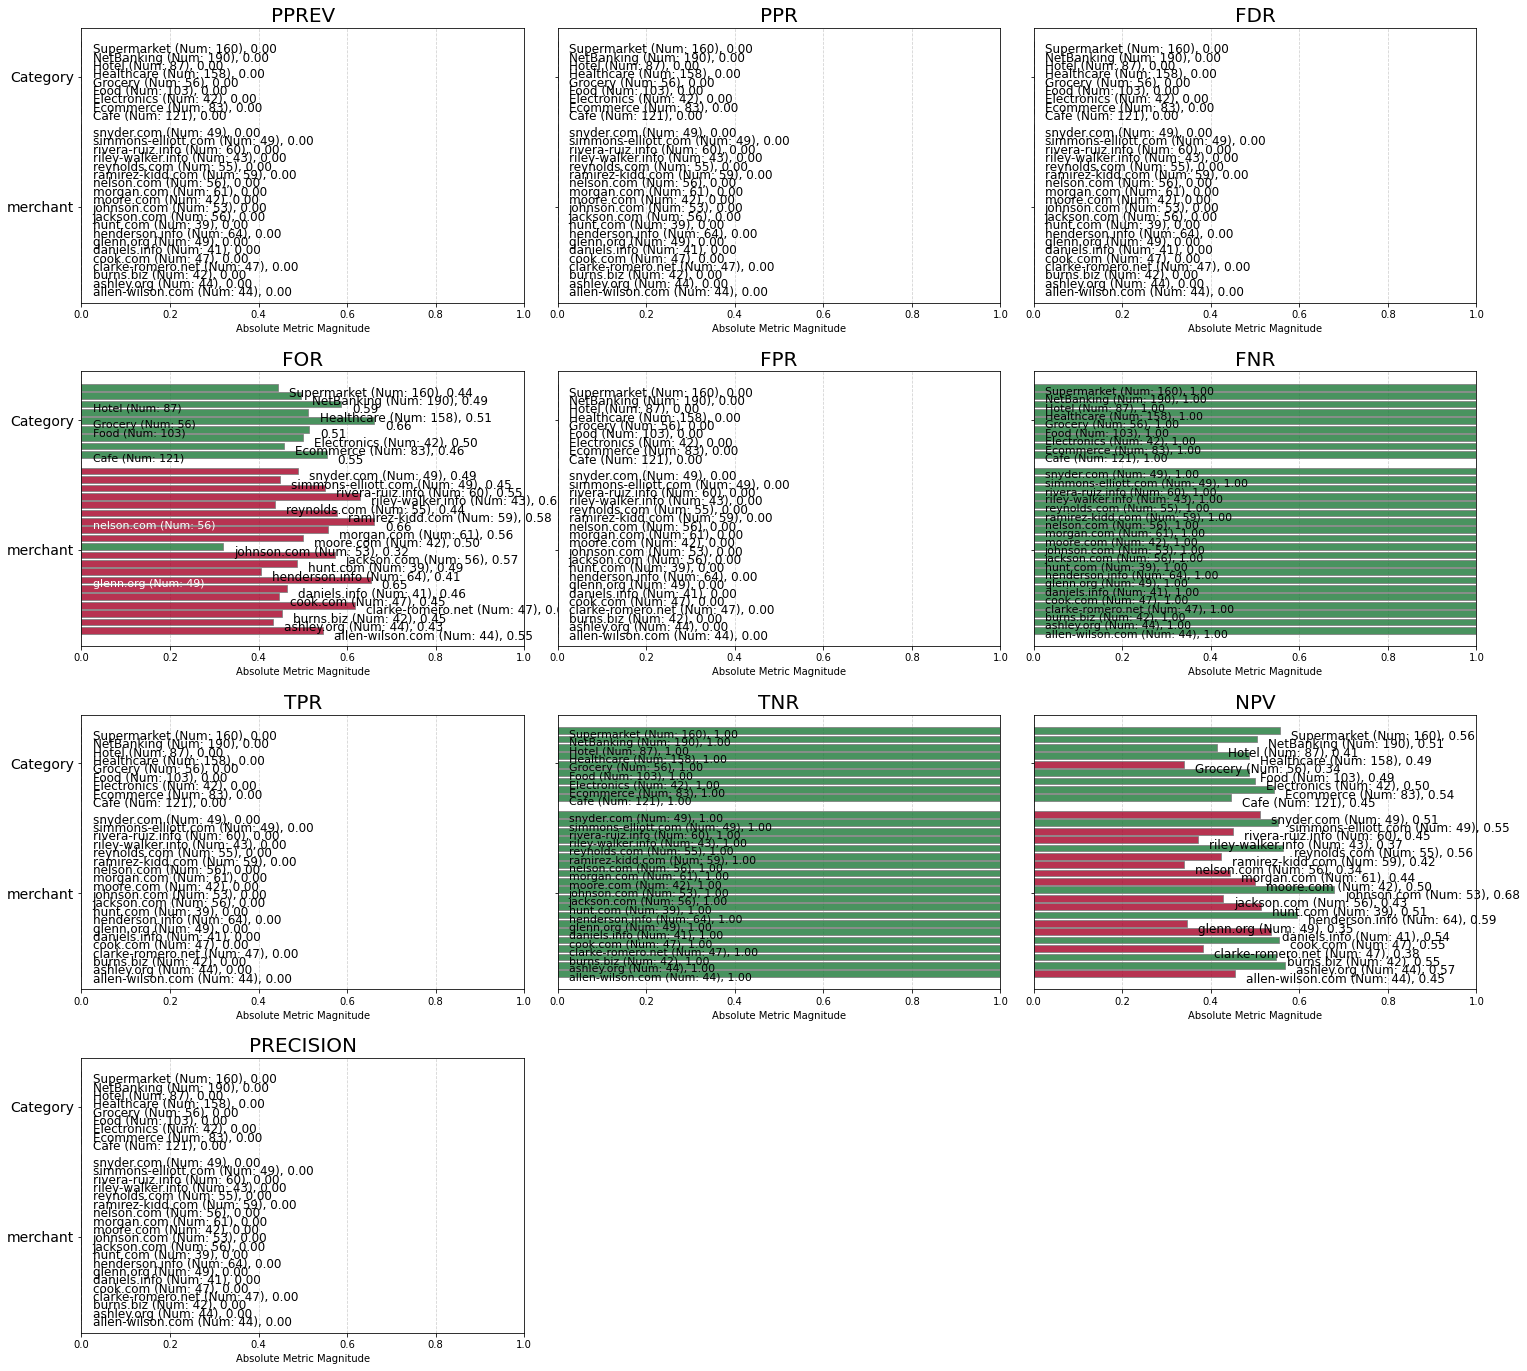

<Figure size 432x288 with 0 Axes>

In [96]:
a13 = analyzer.plot_relative_fairness(ref_group_dict={'Category': 'Cafe', 'merchant': 'johnson.com'})

get_disparity_predefined_group()


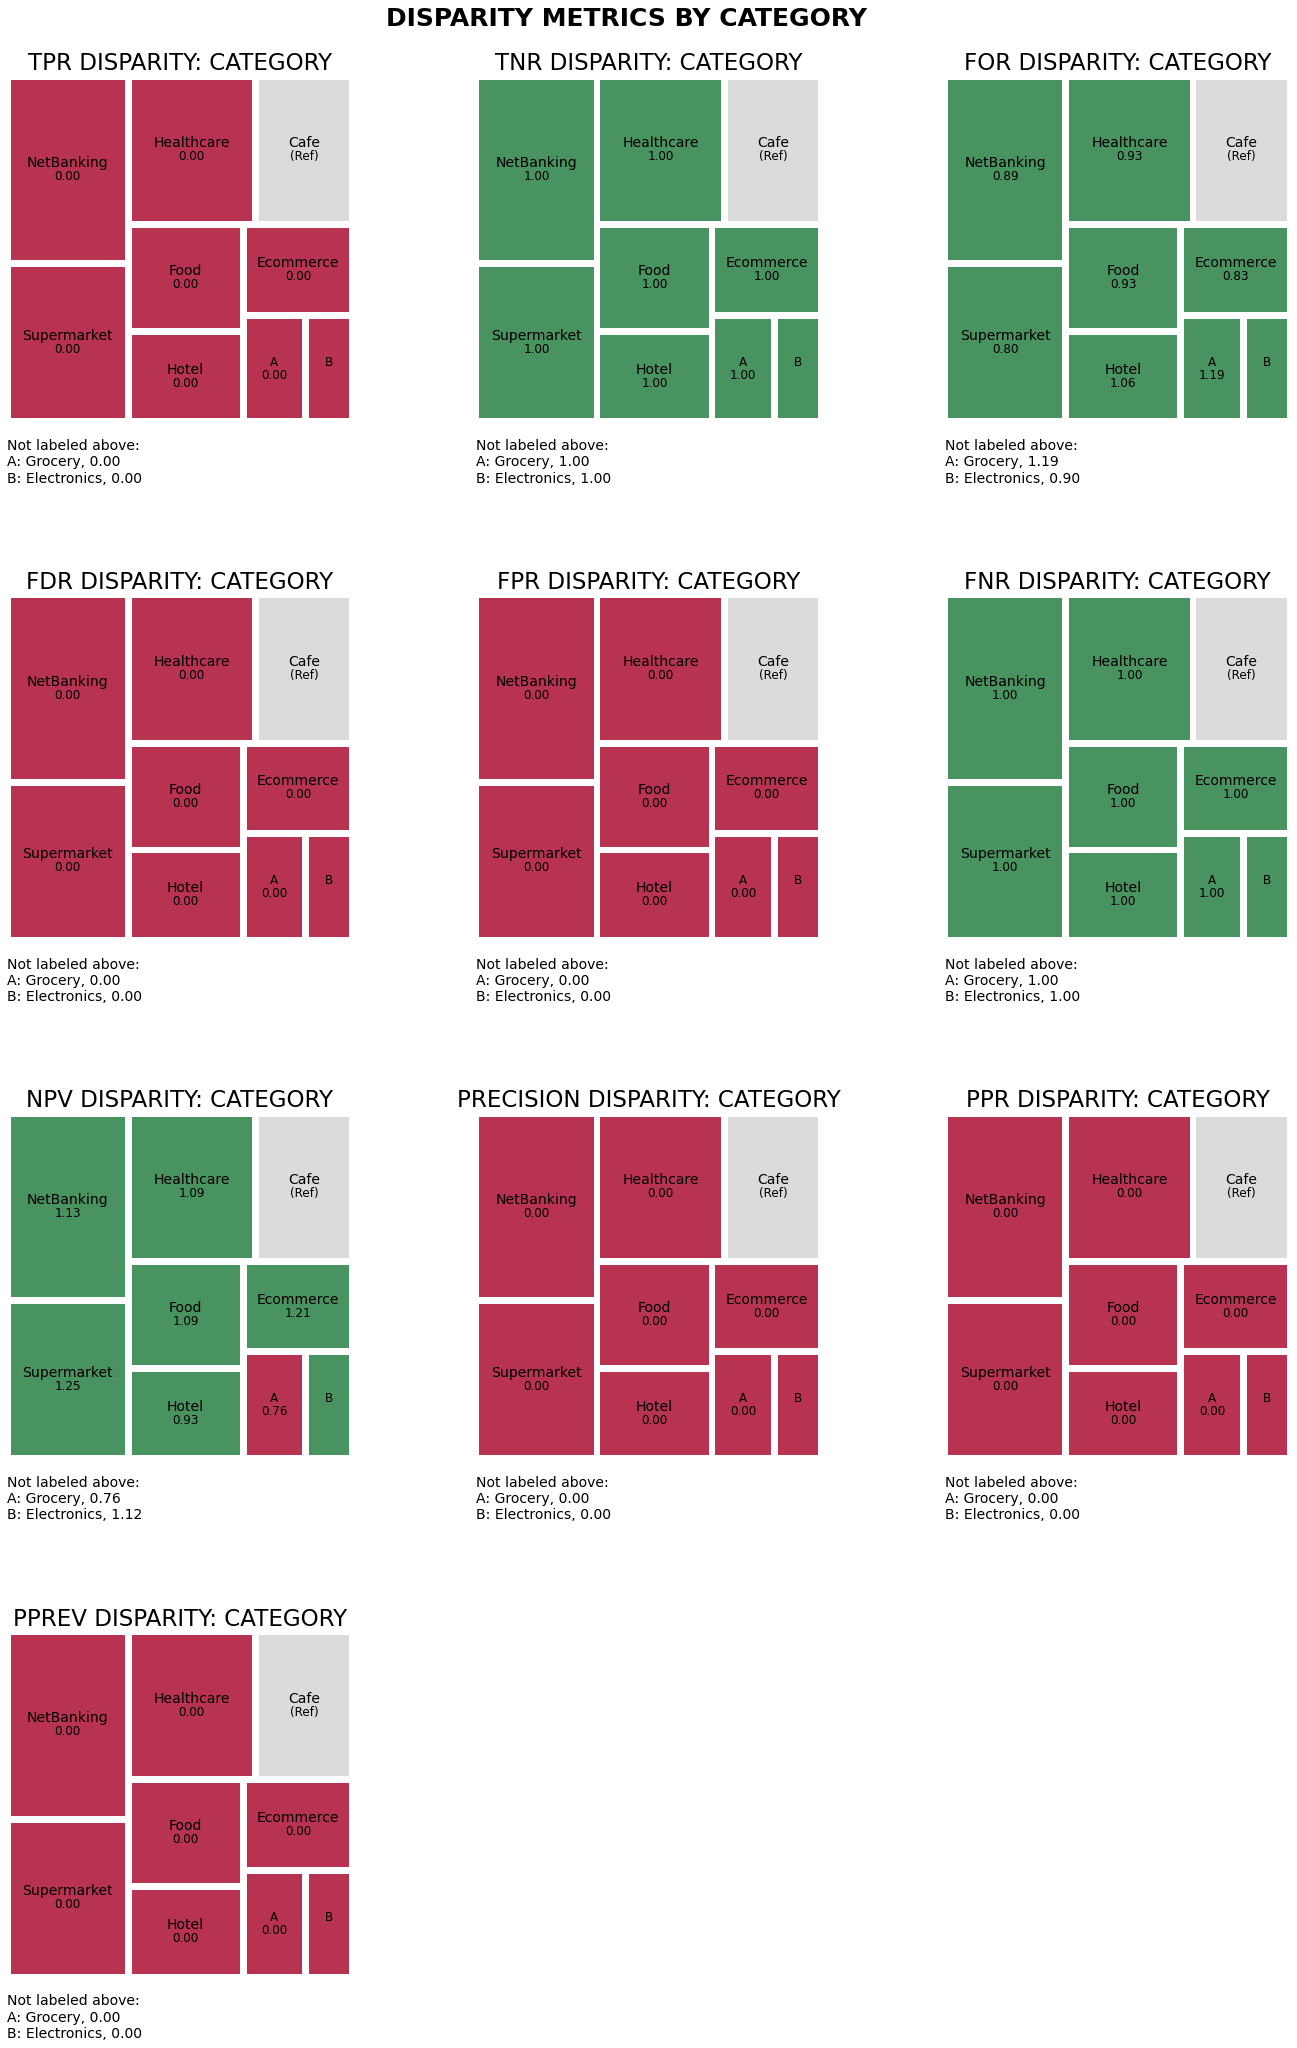

In [97]:
a14 = analyzer.plot_relative_fairness_disparity(ref_group_dict={'Category': 'Cafe', 'merchant': 'johnson.com'}, attrs=['Category'])